In [19]:
from references.colorization.colorizers import *

# load colorizers
colorizer_eccv16 = eccv16(pretrained=True).eval()
colorizer_siggraph17 = siggraph17(pretrained=True).eval()

In [20]:
pokemon_name = "arceus"
IMAGE_DIR = "data/pokemon_png"


# default size to process images is 256x256
# grab L channel in both original ("orig") and resized ("rs") resolutions
img_path = IMAGE_DIR + "/" + pokemon_name + ".png"
img = load_img(img_path)
(tens_l_orig, tens_l_rs) = preprocess_img(img, HW=(256,256))

# colorizer outputs 256x256 ab map
# resize and concatenate to original L channel
img_bw = postprocess_tens(tens_l_orig, torch.cat((0*tens_l_orig,0*tens_l_orig),dim=1))
out_img_eccv16 = postprocess_tens(tens_l_orig, colorizer_eccv16(tens_l_rs).cpu())
out_img_siggraph17 = postprocess_tens(tens_l_orig, colorizer_siggraph17(tens_l_rs).cpu())

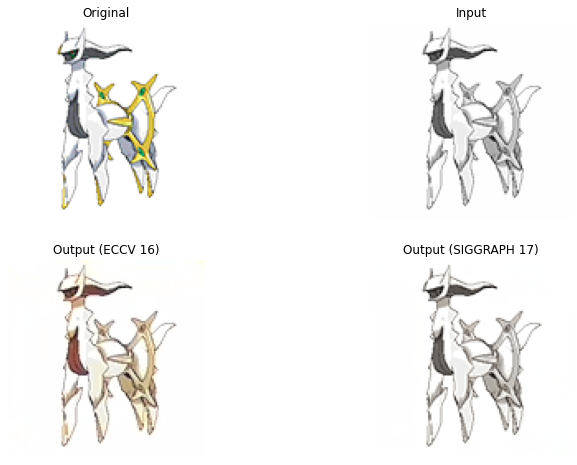

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(img_bw)
plt.title('Input')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(out_img_eccv16)
plt.title('Output (ECCV 16)')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(out_img_siggraph17)
plt.title('Output (SIGGRAPH 17)')
plt.axis('off')
plt.show()

plt.imsave('%s_eccv16.png'%pokemon_name, out_img_eccv16)

In [24]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image

def create_average_image(type, type_to_pokemon_list, in_img, pokemon_name, transfer_function):
    if pokemon_name in type_to_pokemon_list[type]:
        return in_img 
    else:
        img_list = []
        pokemon_list = type_to_pokemon_list[type]
        count = 0
        for pokemon_name_ref in pokemon_list:
            try:
                ref_img = cv2.imread(IMAGE_DIR + "/" + pokemon_name_ref + ".png")
                ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)
                img_list.append(transfer_function(in_img, ref_img))
            except:
                pass
        l = len(img_list)
        avg = Image.fromarray(img_list[0], 'RGB')
        for i in range(1, l):
            avg = Image.blend(avg, Image.fromarray(img_list[i], 'RGB'), 1.0/(i+1))
        return avg

def mean_std_transfer(img_arr_in=None, img_arr_ref=None):
    mean_in = np.ma.array(img_arr_in, mask=img_arr_in[:,:] == np.array([255,128,128])).mean(axis=(0, 1), keepdims=True)
    mean_ref = np.ma.array(img_arr_ref, mask=img_arr_ref[:,:] == np.array([255,128,128])).mean(axis=(0, 1), keepdims=True)
    std_in = np.ma.array(img_arr_in, mask=img_arr_in[:,:] == np.array([255,128,128])).std(axis=(0, 1), keepdims=True)
    std_ref = np.ma.array(img_arr_ref, mask=img_arr_ref[:,:] == np.array([255,128,128])).std(axis=(0, 1), keepdims=True)
    img_arr_out = (img_arr_in - mean_in) / std_in * std_ref + mean_ref
    img_arr_out[img_arr_out < 0] = 0
    img_arr_out[img_arr_out > 255] = 255
    img_arr_out = np.where(img_arr_in[:,:] == np.array([255,128,128]), np.array([255,128,128]), img_arr_out[:,:])
    img_arr_out = np.where(img_arr_in[:,:] == np.array([0,0,0]), np.array([0,0,0]), img_arr_out[:,:])
    return img_arr_out.astype(np.uint8)

def lab_transfer(img_arr_in=None, img_arr_ref=None):
        
        lab_in = cv2.cvtColor(img_arr_in, cv2.COLOR_RGB2LAB)
        lab_ref = cv2.cvtColor(img_arr_ref, cv2.COLOR_RGB2LAB)
        lab_out = mean_std_transfer(img_arr_in=lab_in, img_arr_ref=lab_ref)
        img_arr_out = cv2.cvtColor(lab_out, cv2.COLOR_LAB2RGB)
        return img_arr_out

        
df_poke = pd.read_csv("data/pokemon.csv")

pokemon_type_list = df_poke["Type1"].unique().tolist()
pokemon_type_list.remove("Flying")

type_to_pokemon_list = {}

for pokemon_type in pokemon_type_list :
    type_to_pokemon_list[pokemon_type] = []

for _, row in df_poke.iterrows():
    pokemon_name = row[0]
    pokemon_type1 = row[1]
    
    if pokemon_type1 != "Flying":
        type_to_pokemon_list[pokemon_type1].append(pokemon_name)

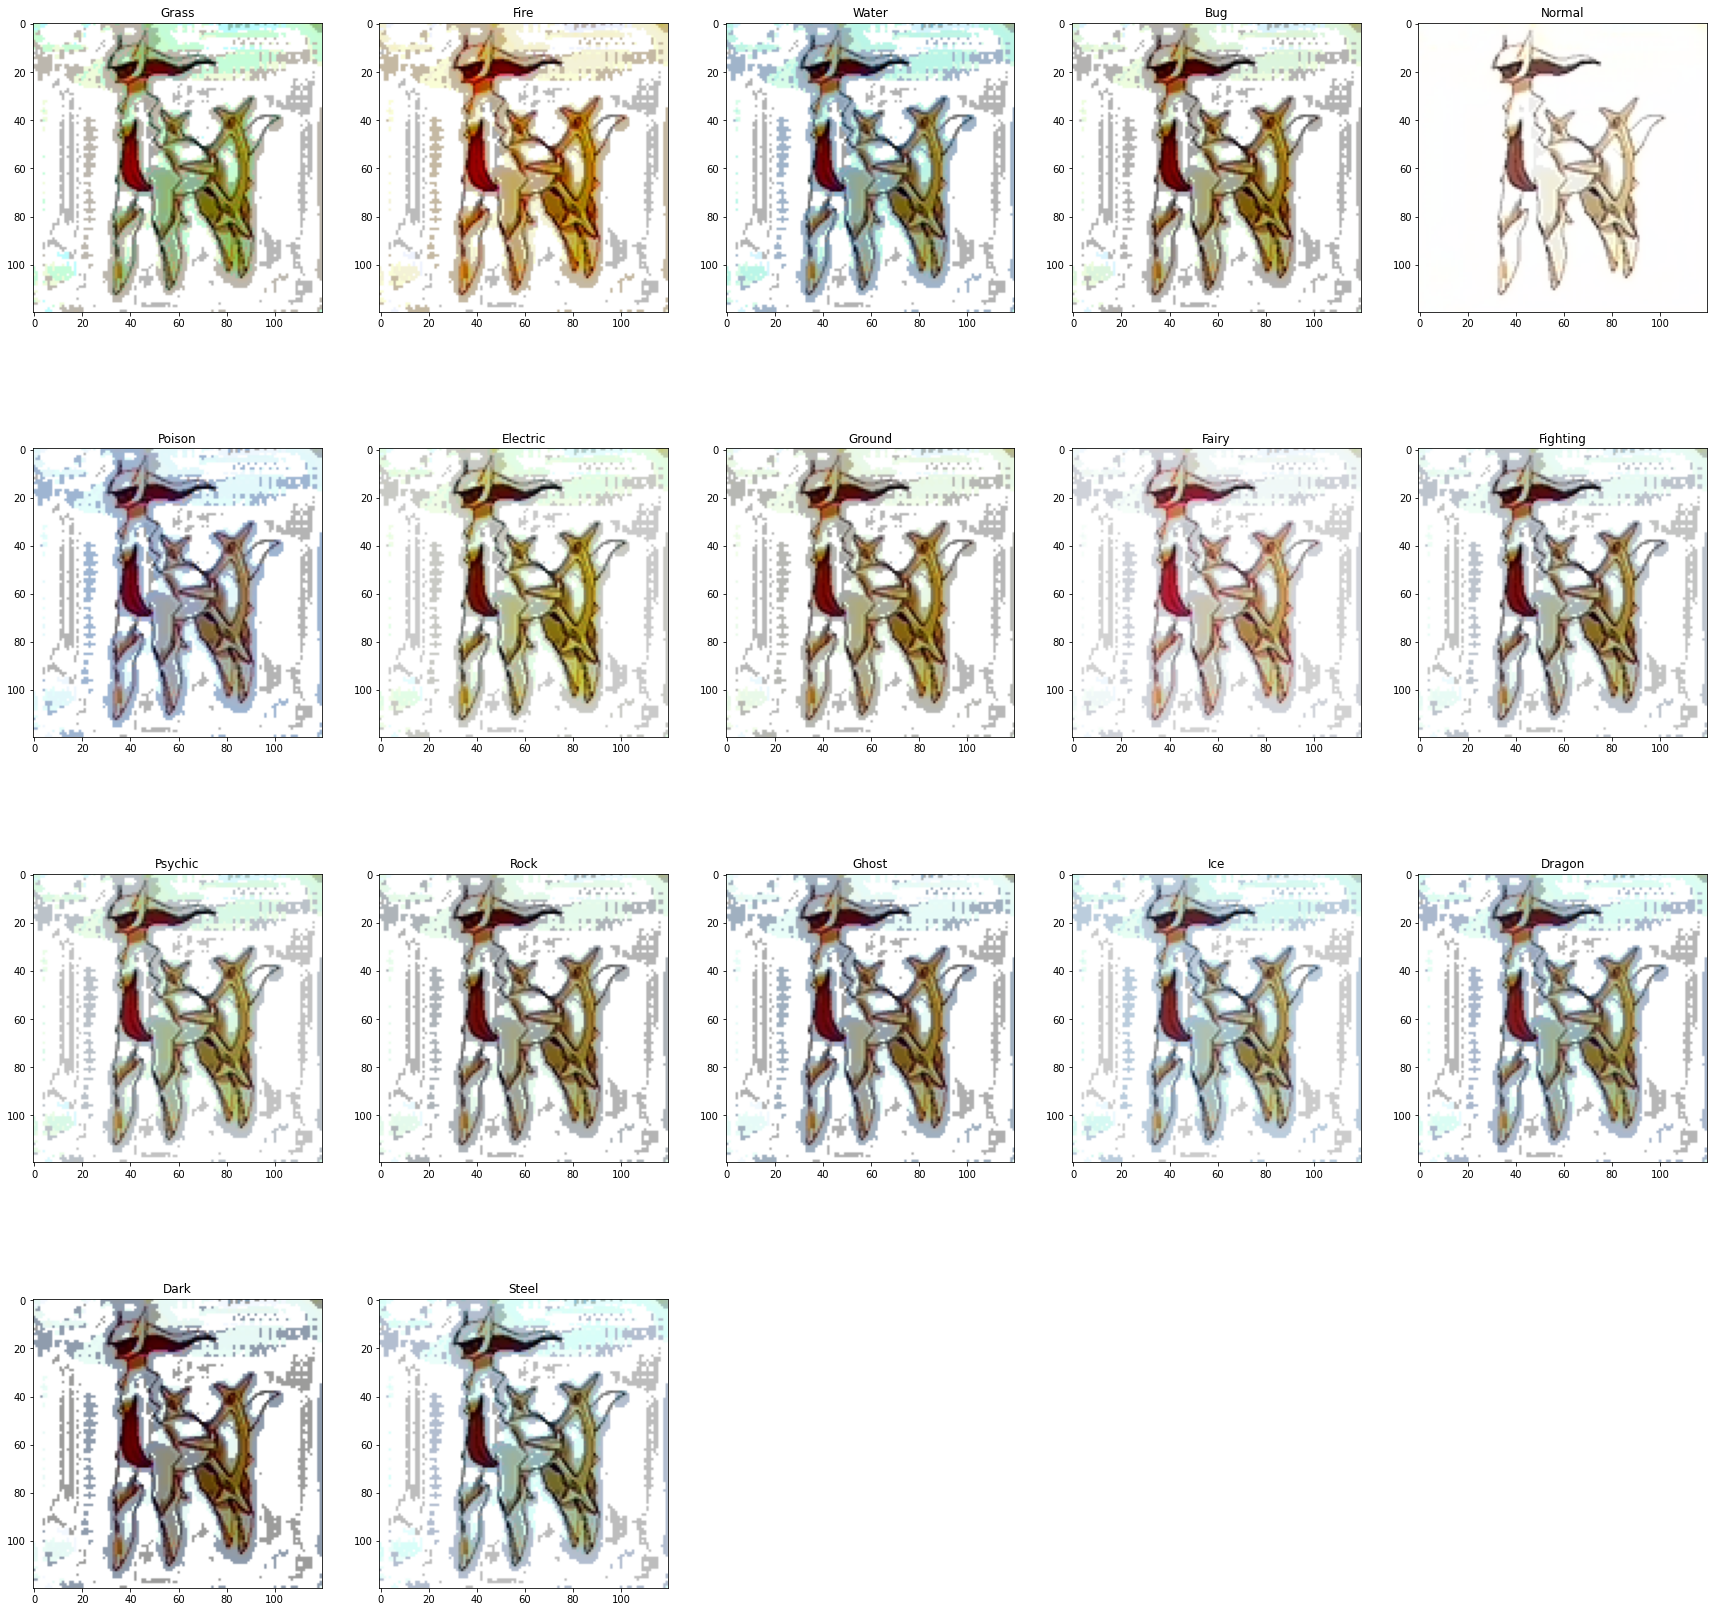

In [22]:
img = '%s_eccv16.png'%pokemon_name

#in_img = cv2.imread(IMAGE_DIR + "/" + pokemon_name + ".png")
in_img = cv2.imread(img)

in_img = cv2.cvtColor(in_img, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(4,5, figsize = (30,30))

x = 0
y = 0
for _, type in enumerate(list(type_to_pokemon_list.keys())):

    average_img = create_average_image(type, type_to_pokemon_list, in_img, pokemon_name, lab_transfer)
    
    ax[x,y].imshow(average_img)
    ax[x,y].title.set_text(type)

    y = (y + 1) % 5
    if y == 0:
        x = (x + 1) % 4

for y in range(1,4):
    fig.delaxes(ax[3,-y])